In [1]:
!nvidia-smi

Thu Mar  4 14:19:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# EYE GAZE SHARED TASK

In [2]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import r2_score
import pickle
from pickle import dump
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk import WordNetLemmatizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, sent_tokenize 
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse = False)
Lemmatizer = WordNetLemmatizer()
vectorizer = TfidfVectorizer(stop_words=None)

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!pip install transformers

     |████████████████████████████████| 1.9MB 18.3MB/s 
     |████████████████████████████████| 890kB 55.6MB/s 
     |████████████████████████████████| 3.2MB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=567058e17f86cf3ae5bc332e99636619981248b5d851461dac5dd0651e912a77
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### IMPORT TRANSFORMERS

In [5]:
#from transformers import BertTokenizer, BertForTokenClassification, BertModel
#from transformers import AlbertTokenizer, AlbertModel
#from transformers import ElectraForTokenClassification, ElectraTokenizer
from transformers import RobertaForTokenClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base", add_prefix_space = True)
base_model = RobertaForTokenClassification.from_pretrained("roberta-base")

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#base_model = BertForTokenClassification.from_pretrained("bert-base-uncased")
#base_model = BertModel.from_pretrained("bert-base-uncased")

#tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
#base_model = ElectraForTokenClassification.from_pretrained("google/electra-small-discriminator")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

### DOWNLOAD DATA

In [6]:
train_data_file_path = "/content/drive/My Drive/CMCL Shared Task/preprocessed_dataset.csv"
test_data_file_path = "/content/drive/My Drive/CMCL Shared Task/preprocessed_test_dataset.csv"
#train_data_file_path = "/content/drive/My Drive/CMCL Shared Task/training_data.csv"
#test_data_file_path = "/content/drive/My Drive/CMCL Shared Task/test_data.csv"

#file_path = "/content/drive/MyDrive/datasets/EyeGazeSharedTask/trial_data.csv"

train_data = pd.read_csv(train_data_file_path)
test_data = pd.read_csv(test_data_file_path)

In [7]:
print("Train Data Shape = ", train_data.shape)
print("Test Data Shape = ", test_data.shape)
df = train_data.copy()
test_df = test_data.copy()

train_data

Train Data Shape =  (15736, 24)
Test Data Shape =  (3554, 19)


,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,-1,3,3,8,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.178778
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,-1,1,4,3,1,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.060409
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,-1,1,5,6,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.178778
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,-1,1,6,7,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.310704
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,-1,1,7,9,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.275261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,-1,1,7,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.118080
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,-1,1,8,7,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.454322
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,-1,1,9,4,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.343320
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.123557


In [8]:
test_data

,sentence_id,word_id,word,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,800,0,It's,-1,2,2,4,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
1,800,1,the,-1,1,3,3,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.108989
2,800,2,funniest,-1,2,5,8,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.519424
3,800,3,American,-1,1,6,8,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.296898
4,800,4,comedy,-1,1,7,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.356212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,990,5,pursued,-1,1,7,7,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.010000
3550,990,6,a,-1,1,8,1,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.800000
3551,990,7,career,-1,1,9,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.398571
3552,990,8,in,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.137170


In [9]:
df_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")
sentences = list(df_data["sentences"])
MAX_LEN = df_data["max_len"][0]

test_df_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Test_Sentences_maxlen.csv")
test_sentences = list(test_df_data["sentences"])
test_MAX_LEN = test_df_data["max_len"][0]

In [10]:
test_sentences[0]

"It's the funniest American comedy since Graffiti Bridge."


























































### PREPROCESS DATA

#### REMOVE EOS TOKEN

In [ ]:
#@title
# FUNCTION TO REMOVE THE <EOS> TOKEN IN THE DATASET

def remove_eos(df, train = True):
  cnt = 1
  if not train:
    cnt = 801
  endword = []
  for i in range(df.shape[0]-1):
    if (df.loc[i+1, "sentence_id"] == cnt):
      df.loc[i, "word"] = df.loc[i, "word"][:-5]   # Remove <EOS> for the last word of each sentence.
      cnt += 1
      endword.append(1)
    else:
      endword.append(-1) 
  s = df.loc[df.shape[0] - 1, "word"]              # Remove <EOS> for last element separately
  df.loc[df.shape[0] - 1, "word"] = s[:-6] 
  endword.append(1)
  df["endword"] = endword
  return df

### COUNT NO OF TOKENS FOR EACH WORD

In [ ]:
#@title
# FUNCTION TO CALCULATE NO OF TOKENS CREATED BY TOKENIZER PER WORD
# ADDS THE DATA IN A NEW COLUMN

def add_token_per_words(df):
  n_tokens_per_word = []
  cdf = 0
  cf_n_token_per_word = []
  for i, word in enumerate(df.word):
    n_tokens_per_word.append(len(tokenizer.encode(word)) - 2)
    if (i > 0) and (df.loc[i-1, "sentence_id"] != df.loc[i, "sentence_id"]):
      cdf = 0
    cdf += len(tokenizer.encode(word)) - 2
    cf_n_token_per_word.append(cdf)
  df["n_tokens"] = n_tokens_per_word
  df["cf_n_tokens"] = cf_n_token_per_word
  return df

add_token_per_words(df)
add_token_per_words(test_df)
df

In [ ]:
test_df

### NO OF CHARS FOR EACH WORD

In [ ]:
#@title
# FUNCTION TO CALCULATE THE NUMBER OF CHARACTERS PER WORD
# ADDS THE DATA IN A NEW COLUMN

def char_per_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)))
  df["n_chars"] = n_chars
  return df

### NO OF CHARS OF WORD - LEMMATIZED WORD

In [ ]:
#@title
# FUNCTION TO CALCULATE THE DIFFERENCE BETWEEN NUMBER OF CHARACTERS IN WORD AND LEMMATIZED WORD
# ADDS AS A NEW COLUMN

def char_per_lemmatized_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)) - len(Lemmatizer.lemmatize(word)))
  df["n_char_lemmatized"] = n_chars
  return df

### STOP WORD OR NOT

In [ ]:
#@title
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#@title
# FUNCTION TO ASSERT WHETHER A WORD IS STOPWORD  OR NOT
# ADDS THE DATA IN A NEW COLUMN

def add_stopword_check(df):
  if_stopword = []
  for word in df.word:
    if word in stop_words:
      if_stopword.append(1)
    else:
      if_stopword.append(-1)

  df["stopword"] = if_stopword
  return df

### NUMBER OR NOT

In [ ]:
#@title
# FUNCTION TO DEFINE WHETHER IT IS A NUMBER OR NOT
# ADDS THE DATA AS A NEW COLUMN

def add_number_check(df):
  if_number = []
  for word in df.word:
    if_number.append(1 if word.isdigit() else -1)

  df["number"] = if_number
  return df

### TF IDF CALCULATION

In [50]:
# FUNCTION TO CALCULATE THE TFIDF OF THE TRAINING DATASET
# ADDS THE DATA IN A NEW COLUMN
# ALSO RETURNS A LIST OF THE SENTENCES

vectorizer = TfidfVectorizer(stop_words = None, token_pattern = r'(?u)\b\S+\b')

bad_words = []
punc = string.punctuation

def remove_punc(word):
  table = str.maketrans('', '', punc)
  return word.translate(table)

def calc_tfidf(df, train=True):
  start_pos = 0
  if not train:
    start_pos = 800
  n = np.array(df["sentence_id"])[-1]
  sentences = []
  tf_idfs = []
  MAX_LEN = 0
  for i in range(start_pos, n+1):   
    temp_df = df[df.sentence_id == i]
    sentence = (' ').join(np.array(temp_df.word))
    sentences.append(sentence)
    MAX_LEN = max(MAX_LEN, len(sentence.split()))
  
  if train:
    tf_idf = vectorizer.fit_transform(sentences)
  else:
    tf_idf = vectorizer.transform(sentences)

  for i, word in enumerate(df.word):
    try:
      tf_idfs.append(tf_idf.toarray()[df["sentence_id"][i]- start_pos][vectorizer.get_feature_names().index(word.lower())])
    except:
      bad_words.append(word)
      if word in ["a", "A", "I"]:
        tf_idfs.append(0.08)
      else:
        tf_idfs.append(0.01)
  df["tf_idf"] = tf_idfs

  return df, bad_words

df, bad_words = calc_tfidf(df)
test_df, test_bad_words = calc_tfidf(test_df, False)

In [51]:
len(bad_words), len(test_bad_words)

(3430, 3430)

In [52]:
bad_words[:10]

['1986,',
 '1987,',
 '1987,',
 'Weinberger,',
 '1.',
 '(except,',
 'course,',
 'Marge)',
 'sarcastic,',
 'demeanours.']

In [ ]:
#@title
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

convert_dict = {"NNS":"NN",
                "PRP":"DT",
                "NN":"NN",
                "NNP":"NNP",
                "DT":"DT",
                "VB":"VB",
                "JJ":"JJ",
                "CD":"CD"}

def pos_tag_func(df, train=True):
  tags = []
  word_tag_tuple = nltk.pos_tag(df["word"])
  for word, tag in word_tag_tuple:
    if tag in convert_dict.keys():
      tags.append(convert_dict[tag]) 
    else:
      tags.append("unk")
  df["tags"] = tags
  
  if train:
    tag_transform = pd.DataFrame(enc.fit_transform(np.array(df.tags).reshape(-1, 1)))
  else:
    tag_transform = pd.DataFrame(enc.transform(np.array(df.tags).reshape(-1, 1)))
  df = pd.concat((df, tag_transform), axis = 1)
  return df

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#@title
def use_transformed_GPT(df):
  df["GPT"] = df["TRT"] - df["GPT"]
  return df

In [ ]:
#@title
# FUNCTION TO PERFORM ALL PREPROCESSING STEPS
def preprocess(df, train = True):
  return calc_tfidf(pos_tag_func(add_number_check(add_stopword_check(char_per_lemmatized_word(char_per_word(add_token_per_words(remove_eos(df, train)))))), train), train)


In [ ]:
#@title
sentences, df, bad_words, MAX_LEN = preprocess(train_data)
test_sentences, test_df, test_bad_words, test_MAX_LEN = preprocess(test_data, False)
df1 = df.copy()
df1

In [14]:
# FUNCTION TO NORMALISE ALL THE TARGET VALUES
from sklearn.preprocessing import MinMaxScaler

training_dataset = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/training_data.csv")
scaler = MinMaxScaler()
def standardize_target(df):
  keys = df.keys()[3:8]
  new_df = pd.DataFrame(scaler.fit_transform(df.iloc[:,3:8]), columns = keys)
  df.update(new_df)
  return 

standardize_target(df)
df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,0,0,Carlucci,0.283976,0.379324,0.061906,0.261297,0.941176,-1,3,3,8,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.176250
1,0,1,was,0.129817,0.288754,0.052640,0.115329,0.764706,-1,1,4,3,1,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.059555
2,0,2,deputy,0.251521,0.474651,0.099264,0.231025,1.000000,-1,1,5,6,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.176250
3,0,3,defense,0.202840,0.429861,0.080925,0.211170,0.882353,-1,1,6,7,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.306310
4,0,4,secretary,0.178499,0.337904,0.045071,0.143640,0.882353,-1,1,7,9,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.271369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,0.114943,0.271777,0.061835,0.096189,0.722222,-1,1,7,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125612
15732,799,5,patient,0.237548,0.427318,0.078262,0.212518,1.000000,-1,1,8,7,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.482584
15733,799,6,wife,0.183908,0.300227,0.086120,0.168475,0.777778,-1,1,9,4,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.364676
15734,799,7,of,0.145594,0.357877,0.118904,0.154469,0.777778,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.131243


In [ ]:
#standardize_target(df)

dump(std_scaler, open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "wb"))

In [ ]:
df.to_csv("/content/drive/My Drive/CMCL Shared Task/preprocessed_dataset.csv", index = False)
test_df.to_csv("/content/drive/My Drive/CMCL Shared Task/preprocessed_test_dataset.csv", index = False)

In [ ]:
sent_len_dict = {'sentences':sentences,
                 "max_len":MAX_LEN}
test_sent_len_dict = {'sentences':test_sentences,
                 "max_len":test_MAX_LEN}

pd.DataFrame(sent_len_dict).to_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")
pd.DataFrame(test_sent_len_dict).to_csv("/content/drive/My Drive/CMCL Shared Task/Test_Sentences_maxlen.csv")

dump(std_scaler, open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "wb"))
dump(vectorizer, open("/content/drive/My Drive/CMCL Shared Task/TfIdfVectorizer.pkl", "wb"))
dump(enc, open("/content/drive/My Drive/CMCL Shared Task/OneHotEncoder.pkl", "wb"))

### FORM TARGETS

In [83]:
# FUNCTION TO FORM TARGETS AND OTHER FEATURES IN SEPARATE DATA STRUCTURES

def form_targets(sentences, df, MAX_LEN, train = True):
  start_pos = 800
  if train:
    start_pos = 0
  n = np.array(df["sentence_id"])[-1] - start_pos
  targets = []
  tags = []
  cdfs = []
  features = {"n_chars" : [],
              "stopword" : [],
              "number" : [],
              "endword":[],
              "n_char_lemmatized" : [],
              "tf_idf" : []
              }

  for i in range(n+1):
    feature = {}
    actual_features = {}
    temp_df = df[df.sentence_id == (i+start_pos)]
    
    cdf = [0 for i in range(MAX_LEN - len(sentences[i].split()))]
    actual_cdf = list(np.array(temp_df.loc[:, "cf_n_tokens"]))
    actual_cdf += cdf

    if train:
      target = [[0, 0, 0, 0, 0] for i in range(MAX_LEN - len(sentences[i].split()))]
      actual_targets = [list(x) for x in np.array(temp_df.iloc[:, 3:8])]
      actual_targets += target

    for key in features.keys():
      feature[key] = [0 for j in range(MAX_LEN - len(sentences[i].split()))]
      actual_features[key] = list(np.array(temp_df.loc[:, key]))
      actual_features[key] += feature[key]

    tag = [[0 for j in range(6)] for k in range(MAX_LEN - len(sentences[i].split()))]
    actual_tag = [list(x) for x in np.array(temp_df.iloc[:, -8:-2])]
    actual_tag += tag

    for key in features.keys():
      features[key].append(actual_features[key]) 
    if train:
      targets.append(actual_targets) 
    tags.append(actual_tag)
    cdfs.append(actual_cdf)

  return targets, features, tags, cdfs


In [84]:
MAX_LEN = 95
targets, features, tags, cdfs = form_targets(sentences, df, MAX_LEN)
print("Target Shape = ", np.array(targets, dtype = "object").shape)
test_targets, test_features, test_tags, test_cdfs = form_targets(test_sentences, test_df, MAX_LEN, False)

Target Shape =  (800, 95, 5)


In [85]:
np.array(tags).shape, np.array(test_tags).shape

((800, 95, 6), (191, 95, 6))

In [63]:
#@title
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


### FORMING CLASS OF DATA

In [86]:
# Class for the data
# Contains 4 keys -> Sentences, targets, input_ids(for BERT), attention_mask(for BERT) 

class EyeGaze_dataset(Dataset):

  def __init__(self, sentences, targets = None, cdfs = None, features = None, tags = None, tokenizer = None, train = True):
    self.sentences = sentences               # List of Sentences
    self.targets = targets                   # List of Padded Targets
    self.tokenizer = tokenizer               # Tokenizer to be used (BERT)
    self.cdfs = cdfs                         # Cumulative Frequency Function
    self.features = features
    self.tags = tags
    self.train = train
    
  def __len__(self):
    return len(self.sentences)               # No of Examples = 100

  def __getitem__(self, index):
    sentence = str(self.sentences[index])        # Get the review at the particular index
    if self.train:
      target = self.targets[index]                    # Get the target label at the particular index
    cdf = self.cdfs[index]
    feature = {}
    for key in features.keys():
      feature[key] = features[key][index]
    tag = tags[index]
    encoding = self.tokenizer.encode_plus(   # Encoder encoding the particular review
        sentence,
        return_attention_mask = True,
        padding = "max_length",
        max_length = MAX_LEN,
        return_tensors = "pt"
    )
    # The class simply returns a dictionary of the following
    if self.train:
      return_dict = {"target":torch.tensor(target, dtype = torch.float32),
                    "input_ids":encoding["input_ids"].flatten(),
                    "attention_mask":encoding["attention_mask"].flatten(),
                    "cdf": torch.tensor(cdf, dtype = torch.int16),
                    "tag":torch.tensor(tag, dtype = torch.float32)}
    else:
      return_dict = {"input_ids":encoding["input_ids"].flatten(),
                    "attention_mask":encoding["attention_mask"].flatten(),
                    "cdf": torch.tensor(cdf, dtype = torch.int16),
                    "tag":torch.tensor(tag, dtype = torch.float32)}
    for key in features.keys():
      return_dict[key] = torch.tensor(feature[key], dtype = torch.float32)

    return return_dict

In [87]:
# Forms the DataLoaders with test_size = 0.2
# Each DataLoader has the Class dataset as their elements
def create_data_loader(sentences, targets, cdfs, features, tags, tokenizer, batch_size, train = True):
  data = EyeGaze_dataset(sentences, targets, cdfs, features, tags, tokenizer, train)
  
  if train:
    train, val = train_test_split(data, test_size = 0.2, shuffle = True)
    train_data_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
    val_data_loader = DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_data_loader, val_data_loader
  test_data_loader = DataLoader(data, batch_size = batch_size, shuffle = False)
  return test_data_loader
  

In [88]:
BATCH_SIZE = 4
train_data_loader, val_data_loader = create_data_loader(sentences, targets, cdfs, features, tags, tokenizer, BATCH_SIZE)
test_data_loader = create_data_loader(test_sentences, None, test_cdfs, test_features, test_tags, tokenizer, BATCH_SIZE, False)

In [89]:

emp = next(iter(train_data_loader))
print(temp.keys())
keys = ['target', 'input_ids', 'attention_mask',  'n_chars', 'n_char_lemmatized', 'cdf', 'stopword', 'number', "tag"]
for key in keys:
  print(temp[key].size())

dict_keys(['target', 'input_ids', 'attention_mask', 'cdf', 'tag', 'n_chars', 'stopword', 'number', 'endword', 'n_char_lemmatized'])
torch.Size([4, 95, 5])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95, 6])


In [90]:
for d in test_data_loader:
  print("tags dims = ", d["tag"].size())

tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 95, 6])
tags dims =  torch.Size([4, 

In [91]:
base_model.config.output_hidden_states = True

In [92]:
class LanguageHeadLayer(torch.nn.Module):
  def __init__(self):
    super(LanguageHeadLayer, self).__init__()
    self.mid = torch.nn.Linear(in_features = base_model.config.hidden_size, out_features = 128)
    self.out = torch.nn.Linear(in_features = 128, out_features = 256)
    self.act1 = torch.nn.ReLU()
    self.act2 = torch.nn.GELU()
    self.drop = torch.nn.Dropout(p = 0.3)

  def forward(self, output):
    output = self.mid(output)
    output = self.act2(output)
    output = self.drop(output)
    output = self.out(output)

    return output
    
class ExtraFeatureModel(torch.nn.Module):
  def __init__(self):
    super(ExtraFeatureModel, self).__init__()
    self.inp = torch.nn.Linear(in_features = 12, out_features = 256)
    self.transformerlayer = torch.nn.TransformerEncoderLayer(d_model = 256, nhead = 8, dim_feedforward = 256, dropout = 0.2, activation = "relu")
    self.transformer = torch.nn.TransformerEncoder(self.transformerlayer, num_layers = 2)
    self.act1 = torch.nn.GELU()
    self.act2 = torch.nn.ReLU()

  def forward(self, features):
    output = self.inp(features)
    output = self.act1(output)
    output = self.transformerlayer(output)
    output = torch.squeeze(output, dim = 0)

    return output

In [93]:

class EyeGazeClassifier(torch.nn.Module):
  def __init__(self):
    super(EyeGazeClassifier, self).__init__()
    self.base_model = base_model
    self.languageheadlayer = LanguageHeadLayer()
    self.feature_model = ExtraFeatureModel()
    self.out = torch.nn.Linear(in_features = 256, out_features = 5)

  def map_predictions(self, outputs, attention_masks, cdfs):
    for i in range(outputs.size()[0]):    
      output = outputs[i]
      attention_mask = attention_masks[i]
      cdf = cdfs[i]

      attention_mask = torch.unsqueeze(attention_mask, dim = 1)

      output = output*attention_mask

      pred_tensor = torch.unsqueeze(torch.mean(output[1:cdf[0]+1], dim = 0), dim = 0)

      for j in range(0, len(cdf)-1):
        if (cdf[j+1] != 0):
          y = torch.unsqueeze(torch.mean(output[cdf[j]+1:cdf[j+1]+1], dim = 0), dim = 0)
          pred_tensor = torch.cat((pred_tensor, y), dim = 0)

      pred_pad = torch.tensor([[0 for a in range(base_model.config.hidden_size)] for k in range(MAX_LEN - pred_tensor.size()[0])], dtype = torch.float32).to(device)
      pred_tensor = torch.cat((pred_tensor, pred_pad), dim = 0)
      if i==0:
        pred_tensors = torch.unsqueeze(pred_tensor, dim = 0)
      else:
        pred_tensors = torch.cat((pred_tensors, torch.unsqueeze(pred_tensor, dim = 0)), dim = 0)

    return pred_tensors

  def forward(self, input_ids, attention_mask, cdf, extra_features):
    lang_output = self.base_model(input_ids = input_ids, attention_mask = attention_mask)
    lang_output = self.map_predictions(lang_output["hidden_states"][-1], attention_mask, cdf)
    lang_output = self.languageheadlayer(lang_output)
    feature_output = self.feature_model(extra_features)
    output = (lang_output+feature_output)/2
    output = self.out(output)
    
    return output


In [94]:
del model

In [95]:
model = EyeGazeClassifier()
model = model.to(device)

### TRAINING

In [73]:
EPOCHS = 120
from transformers import AdamW, get_linear_schedule_with_warmup

opt_params = [{"params": model.languageheadlayer.parameters()},
              {"params": model.feature_model.parameters()},
              {"params": model.out.parameters()}]

partial_optimizer = AdamW(opt_params, lr=2e-7, betas = (0.92, 0.998), correct_bias=False)
total_optimizer = AdamW(model.parameters(), lr = 3e-5, betas = (0.91, 0.998), weight_decay = 0, correct_bias = False)

total_steps = len(train_data_loader) * EPOCHS

partial_scheduler = get_linear_schedule_with_warmup(
  partial_optimizer,
  num_warmup_steps=6,
  num_training_steps=total_steps
)

total_scheduler = get_linear_schedule_with_warmup(
  total_optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.L1Loss(reduction = "mean").to(device)  # reduction = "mean" can be used

In [74]:
#@title
def target_initialise():
  targets = {}
  outputs = {}

  targets["r20"] = torch.tensor([], dtype = torch.float32)
  targets["r21"] = torch.tensor([], dtype = torch.float32)
  targets["r22"] = torch.tensor([], dtype = torch.float32)
  targets["r23"] = torch.tensor([], dtype = torch.float32)
  targets["r24"] = torch.tensor([], dtype = torch.float32)

  outputs["pred_r20"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r21"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r22"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r23"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r24"] = torch.tensor([], dtype = torch.float32)
  
  return targets, outputs

In [75]:
#@title
def store_targets(targets, target):
  targets["r20"] = torch.cat([targets["r20"], target[0,:,0].detach().cpu()], dim = 0)
  targets["r21"] = torch.cat([targets["r21"], target[0,:,1].detach().cpu()], dim = 0)
  targets["r22"] = torch.cat([targets["r22"], target[0,:,2].detach().cpu()], dim = 0)
  targets["r23"] = torch.cat([targets["r23"], target[0,:,3].detach().cpu()], dim = 0)
  targets["r24"] = torch.cat([targets["r24"], target[0,:,4].detach().cpu()], dim = 0)

  return targets  

def store_outputs(outputs, output):
  outputs["pred_r20"] = torch.cat([outputs["pred_r20"], output[0,:,0].detach().cpu()], dim = 0)
  outputs["pred_r21"] = torch.cat([outputs["pred_r21"], output[0,:,1].detach().cpu()], dim = 0)
  outputs["pred_r22"] = torch.cat([outputs["pred_r22"], output[0,:,2].detach().cpu()], dim = 0)
  outputs["pred_r23"] = torch.cat([outputs["pred_r23"], output[0,:,3].detach().cpu()], dim = 0)
  outputs["pred_r24"] = torch.cat([outputs["pred_r24"], output[0,:,4].detach().cpu()], dim = 0)
  
  return outputs

In [96]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()

  losses = []
  targets, outputs = target_initialise()  
  
  r2 = {}
  with torch.autograd.set_detect_anomaly(True):
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
      if_num = torch.unsqueeze(d['number'], dim = 2)
      if_end = torch.unsqueeze(d["endword"], dim = 2)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)
      tag = d["tag"]

      targets = store_targets(targets, target)
      extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, if_end,  tag, tfidf), dim = 2).to(device)

      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )

      outputs = store_outputs(outputs, output)
      
      loss = loss_fn(output, target)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
    
    r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
    r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
    r2["GPT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
    r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
    r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
    
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [97]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()

  losses = []
  outputs = []
  r2 = {}
  targets, outputs = target_initialise()  
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
      if_num = torch.unsqueeze(d['number'], dim = 2)
      if_end = torch.unsqueeze(d["endword"], dim = 2)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)   
      tag = d["tag"]
      targets = store_targets(targets, target)
      extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, if_end, tag, tfidf), dim = 2).to(device)
      
      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )
      
      outputs = store_outputs(outputs, output)
    
      loss = loss_fn(output, target)
      losses.append(loss.item())

  r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
  r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
  r2["GPT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
  r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
  r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
  
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [98]:
def predict_model(model, data_loader, device):
  model = model.eval()
  print("Calculating Predictions on Test Set...\n")
  outputs = []
  _, outputs = target_initialise()  
  final_outputs = []

  with torch.no_grad():
    for batch, d in enumerate(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2).to(device)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2).to(device)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2).to(device)
      if_num = torch.unsqueeze(d['number'], dim = 2).to(device)
      if_end = torch.unsqueeze(d["endword"], dim = 2).to(device)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)  .to(device) 
      tag = d["tag"].to(device)
      extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, if_end, tag, tfidf), dim = 2).to(device)
      
      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )
      
      for i in range(output.size()[0]):
        seq_len = len(test_sentences[i+batch*BATCH_SIZE].split())
        final_outputs += output[i, : seq_len, : ].tolist()

    
  return final_outputs

In [99]:
#@title
def save(history, best):
  for key, value in history.items():
    best[key] = value[-1]

  return best

def update(history, train_loss, val_loss, train_r2, val_r2):
  
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)

  history["train_nFix"].append(train_r2["nFix"])
  history["train_FFD"].append(train_r2["FFD"])
  history["train_GPT"].append(train_r2["GPT"])
  history["train_TRT"].append(train_r2["TRT"])
  history["train_fixProp"].append(train_r2["fixProp"])

  history["val_nFix"].append(val_r2["nFix"])
  history["val_FFD"].append(val_r2["FFD"])
  history["val_GPT"].append(val_r2["GPT"])
  history["val_TRT"].append(val_r2["TRT"])
  history["val_fixProp"].append(val_r2["fixProp"])

  return history

In [100]:
from collections import defaultdict

history = defaultdict(list)
tolerance = 0
best = {}
best = {"val_loss" : 10000}
early_stopping = EarlyStopping(patience = 8, verbose = True, delta = 0.001)

optimizer = total_optimizer
scheduler = total_scheduler

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 120)

  train_loss, train_r2 = train_epoch(model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler)
  

  print(f'Train loss {train_loss} and Train R2 {train_r2}')

  val_loss, val_r2 = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val loss {val_loss} and Val R2 {val_r2}')
  print()

  history = update(history, train_loss, val_loss, train_r2, val_r2)
  
  if val_loss < best["val_loss"]:
    best = save(history, best)
  
  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("Stopped Early at at Epoch ", epoch+1)
    break
  model.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1/120
------------------------------------------------------------------------------------------------------------------------
Train loss 0.135821389593184 and Train R2 {'nFix': -2.446651938227793, 'FFD': 0.266904278910312, 'GPT': -26.82715609101265, 'TRT': -10.441350098383182, 'fixProp': 0.5762040779775282}
Val loss 0.1120630482211709 and Val R2 {'nFix': -0.7339857604355577, 'FFD': 0.8473880751891285, 'GPT': -17.400381451064007, 'TRT': -8.350779788804742, 'fixProp': 0.8814329443819365}

Validation loss decreased (inf --> 0.112063).  Saving model ...
Epoch 2/120
------------------------------------------------------------------------------------------------------------------------
Train loss 0.1291743722278625 and Train R2 {'nFix': -2.3516437316056296, 'FFD': 0.3438399224895089, 'GPT': -24.945895038729283, 'TRT': -9.898840225134528, 'fixProp': 0.7726240958987401}
Val loss 0.11041251588612795 and Val R2 {'nFix': -0.6707552430919013, 'FFD': 0.8634692375297007, 'GPT': -17.3893616164

KeyboardInterrupt: ignored

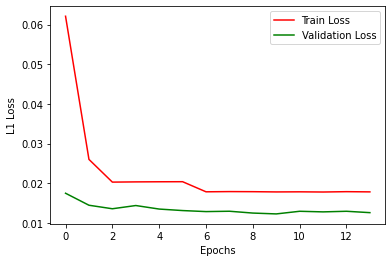

In [42]:
plt.plot(history["train_loss"], c = "r", label = "Train Loss")
plt.plot(history["val_loss"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("L1 Loss")
plt.show()

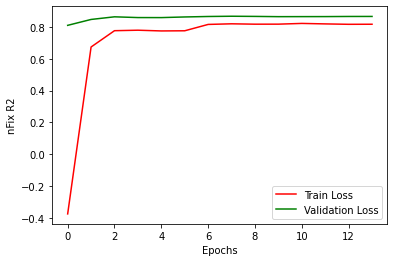

In [43]:
plt.plot(history["train_nFix"], c = "r", label = "Train Loss")
plt.plot(history["val_nFix"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("nFix R2")
plt.show()

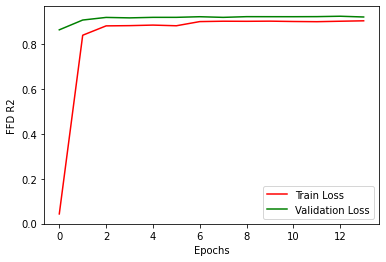

In [44]:
plt.plot(history["train_FFD"], c = "r", label = "Train Loss")
plt.plot(history["val_FFD"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("FFD R2")
plt.show()

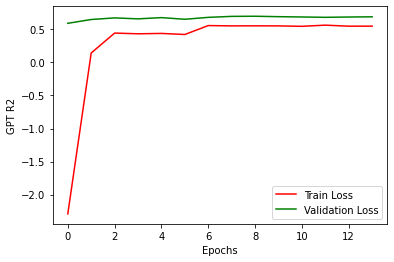

In [45]:
plt.plot(history["train_GPT"], c = "r", label = "Train Loss")
plt.plot(history["val_GPT"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("GPT R2")
plt.show()

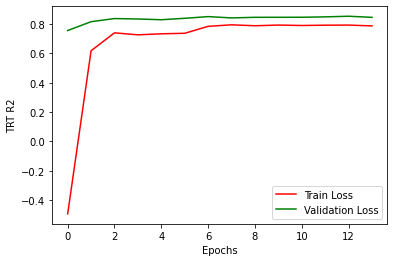

In [46]:
plt.plot(history["train_TRT"], c = "r", label = "Train Loss")
plt.plot(history["val_TRT"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("TRT R2")
plt.show()

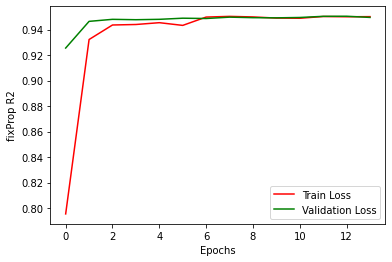

In [47]:
plt.plot(history["train_fixProp"], c = "r", label = "Train Loss")
plt.plot(history["val_fixProp"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("fixProp R2")
plt.show()

In [48]:
train_arr = np.array([best["train_nFix"], best["train_FFD"], best["train_GPT"], best["train_TRT"], best["train_fixProp"]])
val_arr = np.array([best["val_nFix"], best["val_FFD"], best["val_GPT"], best["val_TRT"], best["val_fixProp"]])

train_mean = np.mean(train_arr)
train_std = np.std(train_arr)
train_M = np.max(train_arr)
train_m = np.min(train_arr)
val_mean = np.mean(val_arr)
val_std = np.std(val_arr)
val_M = np.max(val_arr)
val_m = np.min(val_arr)

display_data = [[best["train_loss"], best["train_nFix"], best["train_FFD"], best["train_GPT"], best["train_TRT"], best["train_fixProp"], train_mean, train_std, train_M, train_m],
 [best["val_loss"], best["val_nFix"], best["val_FFD"], best["val_GPT"], best["val_TRT"], best["val_fixProp"], val_mean, val_std, val_M, val_m]]

display_df = pd.DataFrame(display_data, columns = ["L1Loss", "nFix", "FFD", "GPT", "TRT", "fixProp", "Mean", "Std Deviation", "Max", "Min"], index = ["Train", "Val"]) 

In [49]:
display_df

,L1Loss,nFix,FFD,GPT,TRT,fixProp,Mean,Std Deviation,Max,Min
Train,0.017781,0.816333,0.902294,0.552044,0.792740,0.949011,0.802484,0.137433,0.949011,0.552044
Val,0.012231,0.863341,0.922214,0.691510,0.845673,0.949205,0.854389,0.089751,0.949205,0.691510


In [ ]:
save_file_path = "/content/drive/My Drive/CMCL Shared Task/FinalFull_lrdec_RobertaToken2.pth"
torch.save(model.state_dict(), save_file_path)

In [ ]:
cd /content/drive/MyDrive/CMCL Shared Task

/content/drive/.shortcut-targets-by-id/1hd2Ey0O7zwL9GUX-DIniRhuBPaIa4jMC/CMCL Shared Task


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1hd2Ey0O7zwL9GUX-DIniRhuBPaIa4jMC/CMCL Shared Task'

In [ ]:
ls

## LOAD AND RUN MODEL

In [ ]:
save_file_path = "/content/drive/My Drive/CMCL Shared Task/FinalFull_RobertaToken.pth"
model = EyeGazeClassifier()
model.load_state_dict(torch.load(save_file_path, map_location= torch.device("cpu")))
model.eval()

In [ ]:
device='cpu'

In [ ]:
predictions = predict_model(model, test_data_loader, device)

Calculating Predictions on Test Set...



In [ ]:
print(test_df.shape)
np.array(predictions).shape

(3554, 19)


(3554, 5)

In [ ]:
preds = pd.DataFrame(predictions, columns = ["nFix", "FFD", "GPT", "TRT", "fixProp"])
preds

,nFix,FFD,GPT,TRT,fixProp
0,-0.746903,-1.176179,0.272725,-0.777089,-1.494235
1,-0.235995,-0.101616,0.222833,-0.235172,0.050779
2,0.771986,0.633545,0.577571,0.674893,0.776052
3,0.678058,0.776361,0.276146,0.541861,0.895582
4,0.566215,0.722048,0.233776,0.421681,0.879781
...,...,...,...,...,...
3549,1.075185,1.045503,0.302469,0.962088,1.121209
3550,-0.914381,-1.070965,0.185816,-0.861084,-1.206406
3551,0.211890,0.529848,0.136606,0.086831,0.718243
3552,-0.963158,-1.147800,0.187074,-0.963419,-1.167714


In [ ]:
std_scaler = pickle.load(open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "rb"))
final_preds = std_scaler.inverse_transform(preds)
#scaler.inverse_transform(preds)

In [ ]:
final_preds

array([[ 8.06253484e+00,  1.51800675e+00,  2.58595846e-01,
         2.47984354e+00,  2.81189288e+01],
       [ 1.28776258e+01,  3.04648269e+00,  2.17830902e-02,
         4.45323104e+00,  6.83804783e+01],
       [ 2.23774173e+01,  4.09218803e+00,  1.70555961e+00,
         7.76722841e+00,  8.72803860e+01],
       ...,
       [ 1.70987484e+01,  3.94468748e+00, -3.87494111e-01,
         5.62580635e+00,  8.57739372e+01],
       [ 6.02442391e+00,  1.55837294e+00, -1.47946905e-01,
         1.80132391e+00,  3.66277529e+01],
       [ 1.44418938e+01,  3.68695323e+00, -4.71695497e+00,
         5.36665731e+00,  7.01840476e+01]])

In [ ]:
pred_df = pd.DataFrame(final_preds, columns = ["nFix", "FFD", "GPT", "TRT", "fixProp"])
pred_df["GPT"] = pred_df["TRT"] - pred_df["GPT"]
pred_df

,nFix,FFD,GPT,TRT,fixProp
0,8.062535,1.518007,2.221248,2.479844,28.118929
1,12.877626,3.046483,4.431448,4.453231,68.380478
2,22.377417,4.092188,6.061669,7.767228,87.280386
3,21.492190,4.295331,7.007956,7.282794,90.395210
4,20.438116,4.218076,6.771434,6.845159,89.983459
...,...,...,...,...,...
3549,25.234945,4.678164,8.413268,8.813047,96.274844
3550,6.484127,1.667665,2.327894,2.173976,35.619468
3551,17.098748,3.944687,6.013300,5.625806,85.773937
3552,6.024424,1.558373,1.949271,1.801324,36.627753


In [ ]:
training = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/training_data.csv")
gpt_median=training['GPT'].median(axis=0)
gpt_median

4.9898621945771335

In [ ]:
pred_df.min(axis=0)

nFix      -1.163598
FFD        0.037559
GPT       -0.832964
TRT       -0.701886
fixProp   -4.752793
dtype: float64

In [ ]:
pred_df.median(axis=0)

nFix       12.688411
FFD         3.029394
GPT         4.602297
TRT         4.190113
fixProp    66.075285
dtype: float64

In [ ]:
training.median(axis=0)

sentence_id    401.000000
word_id         10.000000
nFix            13.793103
FFD              3.323138
GPT              4.989862
TRT              4.684010
fixProp         75.000000
dtype: float64

In [ ]:
nFix_median= pred_df['nFix'].median(axis=0)
FFD_median= pred_df['FFD'].median(axis=0)
GPT_median=pred_df["GPT"].median(axis=0)
TRT_median= pred_df['TRT'].median(axis=0)
fixProp_median= pred_df['fixProp'].median(axis=0)

In [ ]:
pred_df['nFix'][pred_df['nFix']<0]=nFix_median

In [ ]:
pred_df['FFD'][pred_df['FFD']<0]=FFD_median
pred_df['TRT'][pred_df['TRT']<0]=TRT_median
pred_df['fixProp'][pred_df['fixProp']<0]=fixProp_median
pred_df['GPT'][pred_df['GPT']<0]=GPT_median

In [ ]:
pred_df.min(axis=0)

nFix       0.317864
FFD        0.037559
GPT        0.020445
TRT        0.040823
fixProp    0.122543
dtype: float64

In [ ]:
pred_df

,nFix,FFD,GPT,TRT,fixProp
0,8.062535,1.518007,2.221248,2.479844,28.118929
1,12.877626,3.046483,4.431448,4.453231,68.380478
2,22.377417,4.092188,6.061669,7.767228,87.280386
3,21.492190,4.295331,7.007956,7.282794,90.395210
4,20.438116,4.218076,6.771434,6.845159,89.983459
...,...,...,...,...,...
3549,25.234945,4.678164,8.413268,8.813047,96.274844
3550,6.484127,1.667665,2.327894,2.173976,35.619468
3551,17.098748,3.944687,6.013300,5.625806,85.773937
3552,6.024424,1.558373,1.949271,1.801324,36.627753


In [ ]:
test_dataset = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/test_data.csv")
words=[]
for word in test_dataset.word:
  if (word[-1]==','):
    print(word)
    words.append(word[0:-1])
  else:
    words.append(word)

test_dataset['word']=words
print("Allocation Success")

submission = pd.concat((test_dataset, pred_df), axis = 1)
submission

# SUBMISSION IN CSV FORMAT

The words have been cleaned with comma.

In [ ]:
submission.to_csv('/content/drive/My Drive/CMCL Shared Task/Final_submission.csv', index = False)

In [ ]:
test_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/test_data.csv")

In [ ]:
submission = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Final_submission.csv").drop(columns = ["Unnamed: 0"])

In [ ]:
submission[submission.sentence_id == 801]

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
8,801,0,For,4.405455,1.185462,1.623894,1.770337,26.932640
9,801,1,a,14.572558,3.199163,4.732710,4.727137,72.010990
10,801,2,time,9.955861,2.652689,3.666606,3.382991,58.003232
11,801,3,in,5.888056,1.604610,2.065636,2.001830,36.320494
12,801,4,the,12.675388,3.027912,3.952410,3.899347,66.847478
13,801,5,summer,18.462681,3.948641,5.635072,6.299659,85.119440
14,801,6,of,11.014527,2.457193,3.287323,3.364755,56.628951
15,801,7,1823,23.811235,3.842065,8.777374,9.319907,71.514884
16,801,8,his,10.947636,2.549486,3.247725,3.246673,57.356384
17,801,9,expedition,21.763755,4.266639,6.781774,7.732485,87.628928


In [ ]:
submission.update(test_data)

In [ ]:
submission.to_csv("answer.txt", index = False)

In [ ]:
submission[submission.sentence_id == 801]

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
8,801,0,For,4.405455,1.185462,1.623894,1.770337,26.932640
9,801,1,a,14.572558,3.199163,4.732710,4.727137,72.010990
10,801,2,time,9.955861,2.652689,3.666606,3.382991,58.003232
11,801,3,in,5.888056,1.604610,2.065636,2.001830,36.320494
12,801,4,the,12.675388,3.027912,3.952410,3.899347,66.847478
13,801,5,summer,18.462681,3.948641,5.635072,6.299659,85.119440
14,801,6,of,11.014527,2.457193,3.287323,3.364755,56.628951
15,801,7,"1823,",23.811235,3.842065,8.777374,9.319907,71.514884
16,801,8,his,10.947636,2.549486,3.247725,3.246673,57.356384
17,801,9,expedition,21.763755,4.266639,6.781774,7.732485,87.628928


In [ ]:
words = []
for word in submission.word:
  w = re.sub(",", "", word)
  words.append(w)
submission["word"] = words
submission 

In [ ]:
submission.to_string(index = False, header = False)

' 800   0                           It\'s   8.062535  1.518007   2.221248   2.479844   28.118929\n 800   1                            the  12.877626  3.046483   4.431448   4.453231   68.380478\n 800   2                       funniest  22.377417  4.092188   6.061669   7.767228   87.280386\n 800   3                       American  21.492190  4.295331   7.007956   7.282794   90.395210\n 800   4                         comedy  20.438116  4.218076   6.771434   6.845159   89.983459\n 800   5                          since   7.951005  2.195312   2.904372   2.557039   51.108054\n 800   6                       Graffiti  28.694984  5.127443  14.375143  11.476326   91.636049\n 800   7                   Bridge.<EOS>   9.164567  2.740496  14.163820   3.735293   55.284516\n 801   0                            For   4.405455  1.185462   1.623894   1.770337   26.932640\n 801   1                              a  14.572558  3.199163   4.732710   4.727137   72.010990\n 801   2                           tim

# CONVERTING CSV TO TXT FILE SEPARATED BY COMMA AND DELIMITED BY \n

In [ ]:
s = ''
for column in submission.columns:
  s += str(column)
  s += ","
s = s[:-1]
s += "\n"
with open("/content/drive/My Drive/CMCL Shared Task/Submission_Roberta_21.txt", 'w') as f:
    v = ''
    f.write(s)
    x = submission.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
    vals = [','.join(ele.split()) for ele in x]
    for val in vals:
      v += str(val)
      v += "\n"
    f.write(
        v
    )
    f.close()


In [ ]:
display_data2 = [[history["train_loss"][-1], history["train_nFix"][-1], history["train_FFD"][-1], history["train_GPT"][-1], history["train_TRT"][-1], history["train_fixProp"][-1]], 
                 [history["val_loss"][-1], history["val_nFix"][-1], history["val_FFD"][-1], history["val_GPT"][-1], history["val_TRT"][-1], history["val_fixProp"][-1]]]
display_df2 = pd.DataFrame(display_data2, columns = ["L1Loss", "nFix", "FFD", "GPT", "TRT", "fixProp"], index = ["Train ", "Val "]) 

In [ ]:
display_df2

,L1Loss,nFix,FFD,GPT,TRT,fixProp
Train,0.083993,0.740714,0.709455,0.305041,0.712916,0.771609
Val,0.090722,0.673269,0.630963,0.424405,0.666747,0.671926


In [ ]:
history["train_loss"][0], history["val_loss"][0]

(0.1453631169628352, 0.09576168777421117)

In [ ]:
save_file_path = "/content/drive/My Drive/CMCL Shared Task/Full_Bert_Features_23.pth"
torch.save(model.state_dict(), save_file_path)

In [ ]:
save_file_path = "/content/drive/My Drive/CMCL Shared Task/Bert_Features_21.pth"
model = torch.load(save_file_path)

In [ ]:
MAX_LEN = 95
std_scaler = pickle.load(open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "rb"))
vectorizer = pickle.load(open("/content/drive/My Drive/CMCL Shared Task/TfIdfVectorizer.pkl", "rb"))
enc = pickle.load(open("/content/drive/My Drive/CMCL Shared Task/OneHotEncoder.pkl", "rb"))


test_df, test_sentences, _, test_MAX_LEN = preprocess(test_data)
print("Test Max Len ", test_MAX_LEN)


Test Max Len  47


In [ ]:
temp = test_df
test_df = test_sentences
test_sentences = test_df
test_df

,sentence_id,word_id,word,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,800,0,It's,-1,2,2,4,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
1,800,1,the,-1,1,3,3,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.184085
2,800,2,funniest,-1,2,5,8,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.418186
3,800,3,American,-1,1,6,8,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.330906
4,800,4,comedy,-1,1,7,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.345490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,990,5,pursued,-1,1,7,7,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.376026
3550,990,6,a,-1,1,8,1,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.800000
3551,990,7,career,-1,1,9,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.318702
3552,990,8,in,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.191265


In [ ]:
len(test_sentences)

3554

In [ ]:
del model

In [ ]:
'''
IDEAS:
Training :-
1. Sentence Formation.
2. BERT tokenize.
3. Base BERT Model -> if encoded value == 0 -> 5 output Dense Layer.
4. MAE metric for loss calculation.

Test :-
1. Sentence Formation.
2. BERT Tokenize.
3. Base BERT Model  -> if encoded value == 0 -> 5 output Dense Layer.
4. Order is maintained and predictions are pasted on the csv file.
'''

In [ ]:
'''
trainer = Engine(train_epoch)
train_evaluator = Engine(train_epoch)
validation_evaluator = Engine(val_epoch)

Loss(loss_fn).attach(train_evaluator, "l1")
Loss(loss_fn).attach(validation_evaluator, "l1")

def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return val_loss

handler = EarlyStopping(patience = 10, score_function=score_function, trainer = trainer)
validation_evaluator.add_event_handler(Events.COMPLETED, handler)

def log_training_results(engine):
    train_evaluator.run(train_data_loader)
    metrics = train_evaluator.state.metrics
    pbar.log_message(
        "Training Results - Epoch: {} \nMetrics\n{}"
        .format(engine.state.epoch, pprint.pformat(metrics)))
    
def log_validation_results(engine):
    validation_evaluator.run(val_data_loader)
    metrics = validation_evaluator.state.metrics
    metrics = validation_evaluator.state.metrics
    pbar.log_message(
        "Validation Results - Epoch: {} \nMetrics\n{}"
        .format(engine.state.epoch, pprint.pformat(metrics)))
    pbar.n = pbar.last_print_n = 0

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

checkpointer = ModelCheckpoint('checkpoint', 'textcnn', save_interval=1, n_saved=2, create_dir=True, save_as_state_dict=True)

best_model_save = ModelCheckpoint(
    'best_model', 'textcnn', n_saved=1,
    create_dir=True, save_as_state_dict=True,
    score_function=score_function)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'textcnn': model})
validation_evaluator.add_event_handler(Events.EPOCH_COMPLETED, best_model_save, {'textcnn': model})


trainer.run(train_data_loader, max_epochs=120)
'''